In [95]:
from sklearn.datasets import make_classification

# Generate a 2-class classification dataset with 5 features and 200 instances
X, y = make_classification(n_samples=2000, n_features=20, n_informative=2, n_redundant=0, n_clusters_per_class=1, n_classes=3, random_state=0)

In [79]:
from AITIA.uncertainty_system import UncertaintyEstimator

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [98]:
model = LogisticRegression(random_state=0, max_iter=1000)

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [101]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=0)

In [97]:
us = UncertaintyEstimator(model=model, verbose=True)
us.fit(X_train, y_train)
y_pred, misclassification_risk = us.predict(X_test)

Iteration No: 1 started. Evaluating function at provided point.


KeyboardInterrupt: 

**Misclassification Analysis**

In [114]:
from AITIA.heuristics import KNeighbors, DisjunctSize, DisjunctClass, ClassLikelihood
import statsmodels.api as sm
import scipy.stats as stats
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from zepid.graphics import EffectMeasurePlot
import pandas as pd
import matplotlib.pyplot as plt

In [167]:
class MisclassificationExplainer:
    """
    MisclassificationExplainer class is designed to explain misclassifications made by a predictive model 
    through the analysis of heuristic scores and the generation of various evaluation metrics.

    Parameters:
        - n_neighbors (int, optional): Number of neighbors for the K-nearest neighbors model.
        - max_depth (int, optional): Maximum depth for the DisjunctClass model.
        - balanced (bool, optional): Whether to use balanced classes in the DisjunctClass model.

    Attributes:
        - KDN (KNeighbors): K-nearest neighbors model for calculating disagreement scores.
        - DS (DisjunctSize): DisjunctSize model for calculating DisjunctSize scores.
        - DCP (DisjunctClass): DisjunctClass model for calculating DisjunctClassProbability scores.
        - CLD (ClassLikelihood): ClassLikelihood model for calculating ClassLikelihoodDifference scores.
        - results (dict): Dictionary containing the results of the explanation.

    Methods:
        - fit(X, y, categorical_idx=[]): Fit the internal models to the input data.
        - calculate_heuristics(X, y): Calculate heuristic scores using the fitted models.
        - explain(model, X, y): Explain misclassifications using heuristic scores and logistic regression.
        - plot_results(): Generate plots displaying odds ratios, ROC curves, and Precision-Recall curves.

    Example Usage:
        explainer = MisclassificationExplainer(n_neighbors=10, max_depth=4, balanced=False)
        explainer.fit(X_train, y_train, categorical_idx=[2, 5, 7])
        explainer.explain(model, X_test, y_test)
        explainer.plot_results()
    """

    def __init__(self, n_neighbors=10, max_depth=4, balanced=False):
        self.KDN = KNeighbors(n_neighbors)
        self.DS = DisjunctSize()
        self.DCP = DisjunctClass(max_depth=max_depth, balanced=balanced)
        self.CLD = ClassLikelihood()

    def fit(self, X, y, categorical_idx=[]):
        """
        Fit the internal models to the input data.

        Parameters:
            - X (array-like): Feature matrix.
            - y (array-like): Target labels.
            - categorical_idx (list, optional): List of indices for categorical features.

        Returns:
            None
        """
        self.KDN.fit(X,y)
        self.DS.fit(X,y)
        self.DCP.fit(X,y)
        self.CLD.fit(X, y, categorical_idx=categorical_idx)
    
    def calculate_heuristics(self, X, y):
        """
        Calculate heuristic scores using the fitted models.

        Parameters:
            - X (array-like): Feature matrix.
            - y (array-like): Target labels.

        Returns:
            dict: Dictionary containing heuristic scores.
        """
        KDN_score = self.KDN.calculate_disagreement(X,y)
        DS_score = self.DS.calculate(X)
        DCP_score = self.DCP.calculate_percentage(X,y)
        CLD_score = self.CLD.calculate_class_likelihood_difference(X,y)
        
        return {'KDN_scores': KDN_score,
                'DS_scores': DS_score,
                'DCP_scores': DCP_score,
                'CLD_scores': CLD_score}

    def explain(self, model, X, y):
        """
        Explain misclassifications using heuristic scores.

        Parameters:
            - model: Predictive model with a `predict` method.
            - X (array-like): Feature matrix.
            - y (array-like): Target labels.

        Returns:
            None
        """
        # Make predictions using the provided model
        y_pred = model.predict(X)

        # Identify misclassifications
        misclassifications = y_pred != y

        # Calculate heuristic scores using the implemented method
        scores = self.calculate_heuristics(X, y)

        results = {}
        for heuristic, heuristic_scores in scores.items():
            # Standardize heuristic scores using z-score normalization
            heuristic_scores_ = stats.zscore(heuristic_scores)
            # Add a constant term for logistic regression
            heuristic_scores_ = sm.add_constant(heuristic_scores_)
            
            # Fit logistic regression model to predict misclassifications using heuristic scores
            res = sm.Logit(misclassifications, heuristic_scores_).fit()

            # Calculate Area Under the Receiver Operating Characteristic (AUROC) and Area Under the Precision-Recall Curve (AUPRC) score
            auroc = roc_auc_score(misclassifications, heuristic_scores)
            auprc = average_precision_score(misclassifications, heuristic_scores)

            # Generate ROC and Precision-Recall curve
            fpr, tpr, _ = roc_curve(misclassifications, heuristic_scores)
            precision, recall, _ = precision_recall_curve(misclassifications, heuristic_scores)

            # Store results for the current heuristic
            results[heuristic] = {
                'odds_ratio': np.exp(res.params[1]).round(3),
                'confidence_interval': np.exp(res.conf_int()[1,:]).round(3),
                'pvalue': res.pvalues[1].round(3),
                'auroc': auroc.round(3),
                'auprc': auprc.round(3),
                'roc_curve': {'fpr': list(fpr), 'tpr': list(tpr)},
                'precision_recall_curve': {'precision': list(precision), 'recall': list(recall)}
            }
        
        self.results = results

    def plot_results(self):
        """
        Generate plots displaying odds ratios, ROC curves, and Precision-Recall curves.

        Parameters:
            None

        Returns:
            None
        """
        # Produce forest plot for the odds ratios
        p = EffectMeasurePlot(label=[k for k in self.results.keys()], 
                              effect_measure=[v['odds_ratio'] for v in self.results.values()],
                            lcl=[v['confidence_interval'][0] for v in self.results.values()], 
                            ucl=[v['confidence_interval'][1] for v in self.results.values()])

        p.labels(effectmeasure='OR')
        p.colors(pointshape="D")
        ax=p.plot(figsize=(15,5), 
                  t_adjuster=0.09, 
                  max_value=int(np.ceil(max([v['confidence_interval'][1] for v in self.results.values()])*1.1)), 
                  min_value=int(0))
        ax.set_title('A) Odd Ratios')
        
        # Produce the ROC curves
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
        
        legend = []
        for k, v in self.results.items():
            axes[0].plot(v['roc_curve']['fpr'], v['roc_curve']['tpr'], alpha=1)
            legend.append(f'{k}, AUROC = {np.round(v["auroc"], 2)}')
        
        axes[0].legend(legend, loc='lower right')
        axes[0].plot([0, 1], [0, 1], 'r--', alpha=0.2)
        axes[0].set_xlim([-0.01, 1.01])  # 'xlim' and 'ylim' instead of 'set_xlim' and 'set_ylim'
        axes[0].set_ylim([-0.01, 1.01])
        axes[0].set_ylabel('True Positive Rate')
        axes[0].set_xlabel('False Positive Rate')
        axes[0].set_title('B) AUROC')

        # Produce the Precision-Recall curves
        legend = []
        for k, v in self.results.items():
            axes[1].plot(v['precision_recall_curve']['recall'], v['precision_recall_curve']['precision'], alpha=1)
            legend.append(f'{k}, AUPRC = {np.round(v["auprc"], 2)}')

        axes[1].set_xlim([-0.01, 1.01])  # 'xlim' and 'ylim' instead of 'set_xlim' and 'set_ylim'
        axes[1].set_ylim([-0.01, 1.01])
        axes[1].set_ylabel('Precision')
        axes[1].set_xlabel('Recall')
        axes[1].legend(legend, loc='upper right')
        axes[1].set_title('C) AUPRC')

In [168]:
me = MisclassificationExplainer()
me.fit(X_train,y_train)
me.explain(model, X_test,y_test)

Optimization terminated successfully.
         Current function value: 0.134316
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.173176
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.139336
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.212890
         Iterations 7


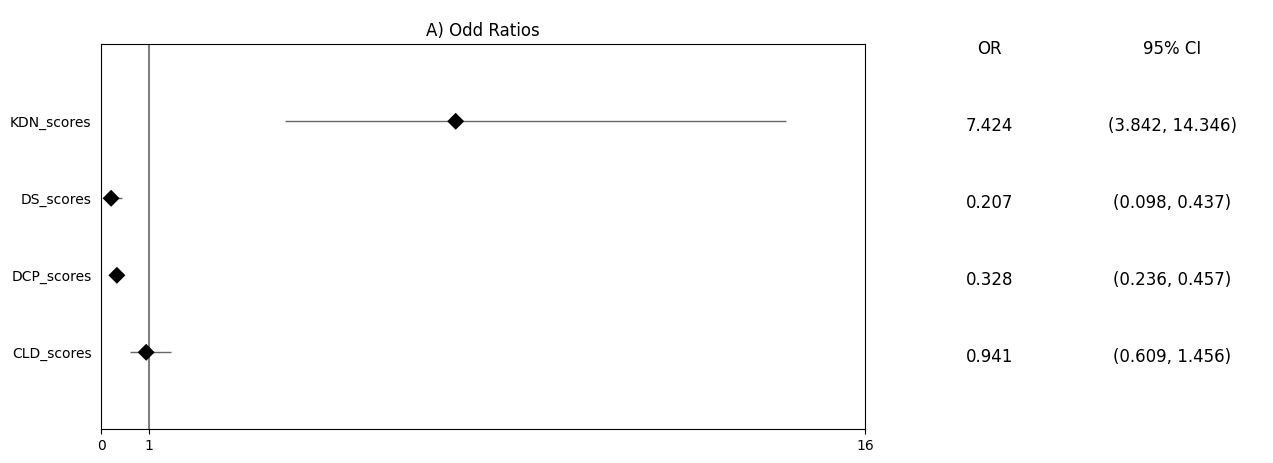

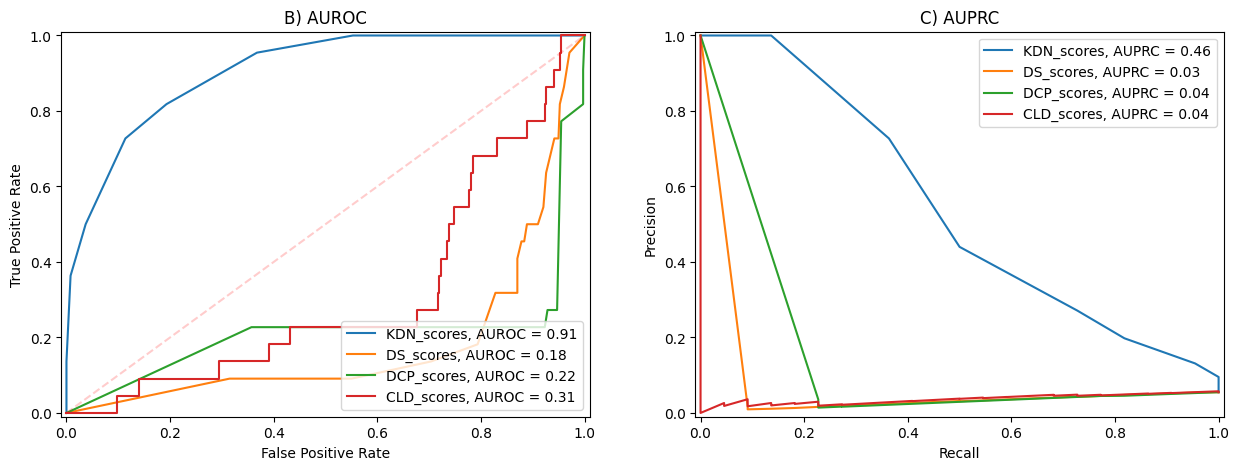

In [169]:
me.plot_results()